### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18/tree/master/notebooks/Week-9-Tue.ipynb


# Week 9, Tuesday: Density estimation and clustering.

In [47]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

## Mixture models

We frequently encounter cases where we obtain data that show certain multi-modal behavior (i.e., have "multiple peaks"). It's useful to try to see whether a ***mixture*** of simple models (typically, Gaussians) can explain the data, and how many simple models are sufficient to explain the data.

Examples:
* Unresolved ("blended") stars that are very close together.
* Overlapping stellar systems
* Overlapping asteroid families
* ... many others ...

Questions:
* What is the number of components in the mixture that best explains the data?
* What are the values of those components' parameters?

Below is an example of a simulated datasets with 4 Gaussian components, with observational errors, and our fit to those data.

In [48]:
### Modeled after astroML book figure 4.2  

from sklearn.mixture import GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.0, Nmax=10, Niter=100):
    #------------------------------------------------------------
    # Set up the dataset.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand.
    np.random.seed(1)
    gmm = GMM(4, n_iter=1)
    gmm.means_ = np.array([[-4], [-1], [0.9], [3]])
    gmm.covars_ = np.array([[1.1], [1.0], [0.7], [0.8]]) ** 2
    gmm.weights_ = np.array([0.2, 0.3, 0.2, 0.3])

    X = gmm.sample(Ndata)
    # convolution by "measurement" errors
    X = np.random.normal(X, noiseStd)
    
    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-Nmax components
    N = np.arange(1, Nmax+1)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GMM(N[i], n_iter=Niter).fit(X)

    # compute the BIC
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(-10, 10, 1000)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1))) ## fix
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 'auto', normed=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()  
        
    #print(M_best.means_)
    #print(M_best.weights_)

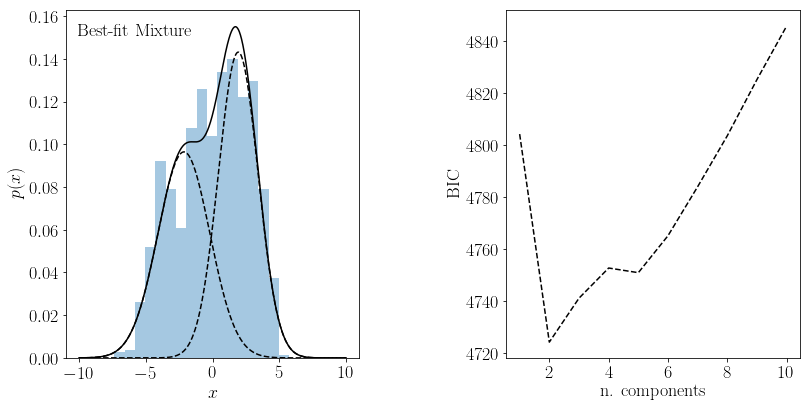

In [49]:
doGMM(1000) 

##  How do we interpret BIC? 

The figure above (right panel) shows that the 2-component model has a BIC lower
by about 15 than the 3-component model. Is this sufficient evidence to claim 
that the former is really really better choice than the latter? 

As you may recall, we said in Week 4 Thu lecture:

**How do we interpret the values of the odds ratio in practice? **
Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

Given the relationship between the BIC and $O_{21},$ 
$$    \Delta BIC \equiv BIC_2 - BIC_1 = -2\,\ln(O_{21}) $$ 
we have that $O_{21}=10$ corresponds to $\Delta BIC= -4.6$ and $O_{21}=100$ corresponds to $\Delta BIC = -9.2$.
For completeness, $|\Delta BIC|<2$ is “not worth more than a bare mention.”

Therefore, ** $|\Delta BIC| = 5$ corresponds to “strong” evidence and $|\Delta BIC| = 10$ to “decisive” evidence.**

We can conclude that the figure shows **decisive** evidence in favor of the 2-component model. That is,
you should **not** argue that there are 3 peaks in the left panel! Altough we **did** draw that dataset
from a model with more than 2 components (4 actually), a sample of 1000 values is insufficient to 
*discover* more than 2 components!

What if we increase the sample size? 

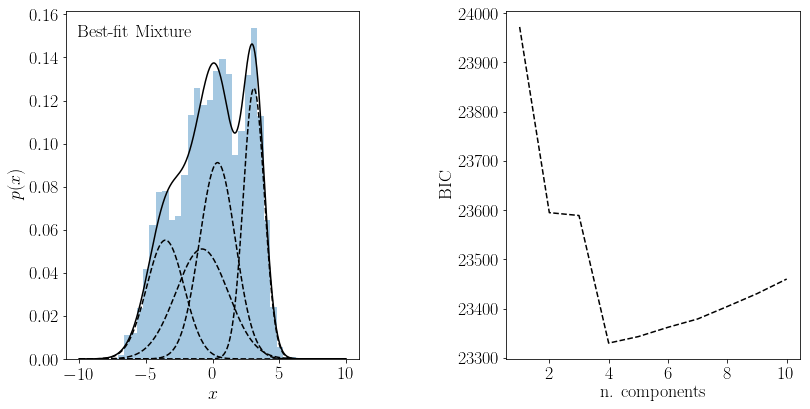

In [50]:
doGMM(5000)

**Conclusion** Large sample size helps! I love surveys, I love LSST! 

But one more thing: let's convolve our data with an arbitrary Gaussian 
to simulate measurement errors. 

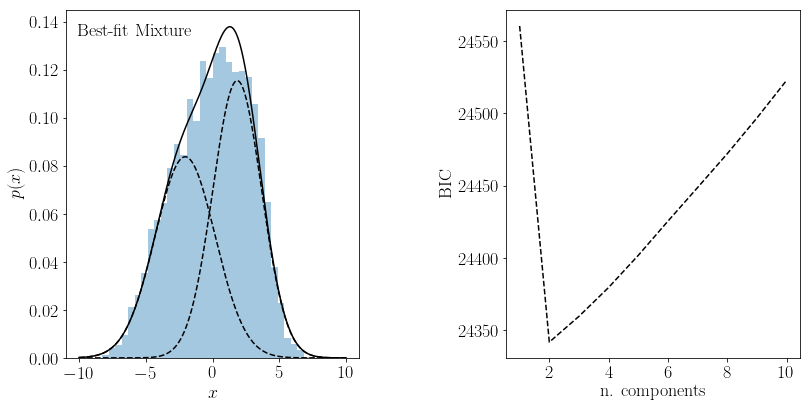

In [51]:
doGMM(5000,1.0)

**Conclusion** Duh! If you badly "blur" your sample, of course you will not see the fine
structure (i.e. many components)! 

Therefore, even with large samples, you still need to have precise and well calibrated 
measurements! Another reason to love LSST! 
 